In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


1.13.1
sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.21.2
tensorflow 1.13.1
tensorflow._api.v1.keras 2.2.4-tf


In [2]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [3]:
word_index = imdb.get_word_index()
print(len(word_index))
print(word_index)

88584
{'cathryn': 24118, '45min': 61307, 'masumura': 46991, 'tempo': 12750, 'schwarzeneggar': 39805, 'lomax': 73249, 'derm': 59681, 'stanislavski': 85002, 'zenia': 11288, "bono's": 73270, "chow's": 34033, "wishman's": 42282, 'boppity': 65752, 'finneys': 65393, 'time': 55, 'outdoors': 12946, "road'": 45343, 'woodthorpe': 42370, 'puya': 88383, 'recognised': 10344, 'jody': 20952, 'feore': 24550, 'riba': 31871, '1832': 70266, 'kinlan': 80981, 'peepers': 21716, 'admitt': 66789, 'untreated': 66239, 'semebene': 76140, "rooneys'": 49525, "hills'": 45626, "it's'": 60723, 'manlis': 55219, "fields'": 39318, 'commemorative': 74254, '01': 12347, 'explication': 62492, 'shattered': 10692, 'marja': 50580, 'luis': 6042, 'nail': 4420, 'life': 110, 'jaffa': 19498, 'defeated': 5762, 'felix': 4015, 'tali': 63541, "bombshells'": 30841, 'tories': 30996, 'inamdar': 51673, 'litten': 46334, 'doofus': 37952, 'temporary': 9129, 'pevensie': 66037, 'ghungroo': 43949, 'swells': 23964, 'blom': 37664, 'retrospect': 99

In [4]:
word_index = {k:(v+3) for k, v in word_index.items()}

In [5]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [6]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [7]:
embedding_dim = 16
batch_size = 512

single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.SimpleRNN(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


Train on 20000 samples, validate on 5000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
20000/20000 [==============================] - 17s 857us/sample - loss: 0.6944 - acc: 0.4997 - val_loss: 0.6944 - val_acc: 0.5030
Epoch 2/30
20000/20000 [==============================] - 16s 790us/sample - loss: 0.6937 - acc: 0.5054 - val_loss: 0.6933 - val_acc: 0.5068
Epoch 3/30
20000/20000 [==============================] - 16s 780us/sample - loss: 0.6955 - acc: 0.5059 - val_loss: 0.6939 - val_acc: 0.4926
Epoch 4/30
20000/20000 [==============================] - 16s 807us/sample - loss: 0.6949 - acc: 0.5036 - val_loss: 0.6936 - val_acc: 0.5024
Epoch 5/30
20000/20000 [==============================] - 16s 792us/sample - loss: 0.6956 - acc: 0.4981 - val_loss: 0.6988 - val_acc: 0.4942
Epoch 6/30
20000/20000 [==============================] - 16s 813us/sample - loss: 0.6984 - acc: 0.4992 - val_loss: 0.6953 - val_acc: 0.4938
Epoch 7/30
20000/20000 [==============================] -

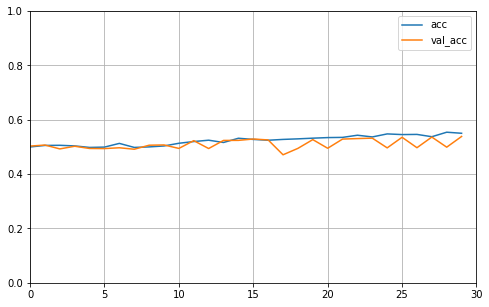

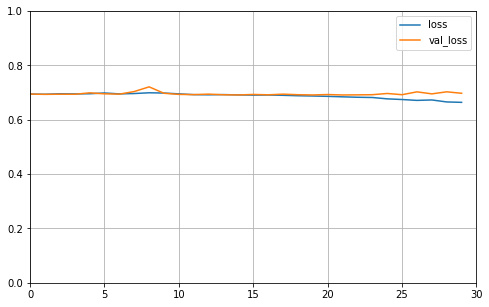

In [9]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_rnn, 'acc', 30, 0, 1)
plot_learning_curves(history_single_rnn, 'loss', 30, 0, 1)

In [10]:
single_rnn_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,)

25000/25000 [==============================] - 10s 391us/sample - loss: 0.7003 - acc: 0.5262


[0.7003052920341492, 0.52624]

In [13]:
embedding_dim = 16
batch_size = 512

model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = True)),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 128)          10368     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 44s 2ms/sample - loss: 0.6957 - acc: 0.5030 - val_loss: 0.6972 - val_acc: 0.5072
Epoch 2/30
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.6915 - acc: 0.5301 - val_loss: 0.6926 - val_acc: 0.5298
Epoch 3/30
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.6722 - acc: 0.5824 - val_loss: 0.7087 - val_acc: 0.5290
Epoch 4/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.5778 - acc: 0.6992 - val_loss: 0.9623 - val_acc: 0.5258
Epoch 5/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.4075 - acc: 0.8177 - val_loss: 0.9605 - val_acc: 0.5516
Epoch 6/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.2103 - acc: 0.9210 - val_loss: 1.3026 - val_acc: 0.5486
Epoch 7/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.0791 - acc: 0.9750 - val_loss: 1.7

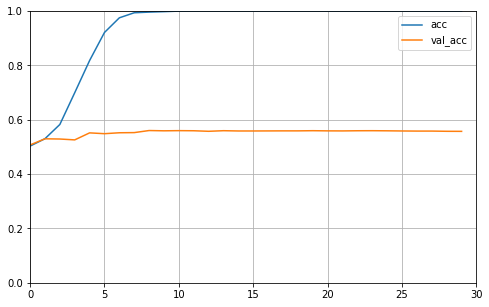

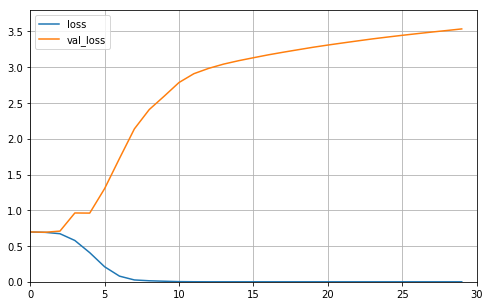

In [18]:
plot_learning_curves(history, 'acc', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 3.8)

In [19]:
embedding_dim = 16
batch_size = 512

bi_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                3136      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.6935 - acc: 0.5081 - val_loss: 0.6923 - val_acc: 0.5190
Epoch 2/30
20000/20000 [==============================] - 20s 993us/sample - loss: 0.6819 - acc: 0.5756 - val_loss: 0.6930 - val_acc: 0.5248
Epoch 3/30
20000/20000 [==============================] - 18s 924us/sample - loss: 0.6183 - acc: 0.6831 - val_loss: 0.6886 - val_acc: 0.5960
Epoch 4/30
20000/20000 [==============================] - 19s 944us/sample - loss: 0.3840 - acc: 0.8417 - val_loss: 0.7681 - val_acc: 0.6774
Epoch 5/30
20000/20000 [==============================] - 19s 936us/sample - loss: 0.2939 - acc: 0.8846 - val_loss: 0.5624 - val_acc: 0.7658
Epoch 6/30
20000/20000 [==============================] - 19s 926us/sample - loss: 0.1026 - acc: 0.9671 - val_loss: 0.7213 - val_acc: 0.7264
Epoch 7/30
20000/20000 [==============================] - 19s 930us/sample - loss: 0.0345 - acc: 0.9937 - v

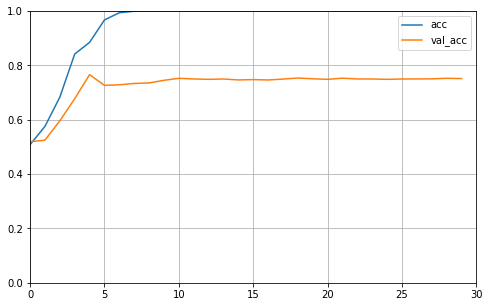

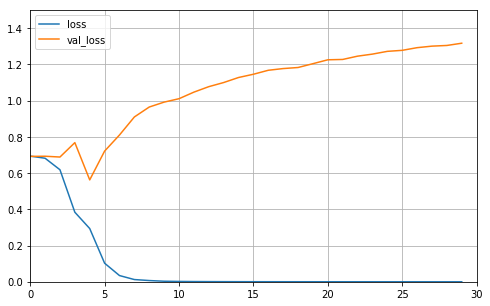

In [21]:
plot_learning_curves(history, 'acc', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1.5)

In [22]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size)

25000/25000 [==============================] - 10s 390us/sample - loss: 1.4077 - acc: 0.7332


[1.4076779971313476, 0.73316]